## Explaining Graph Neural Networks

Explainability in AI refers to the ability of AI models, especially complex ones like deep learning models, to provide **understandable**, **interpretable**, and **transparent** explanations for their decisions and predictions. In other words, it aims to make the "black box" of AI more transparent, so that humans can understand why an AI system made a particular choice.

In GNNs, information propagates across the graph, meaning that decisions are often influenced by distant nodes or multi-hop neighbors. *Explaining which nodes and paths influenced a specific prediction can be complex.* Explaining GNNs is a new field that takes a lot of ideas from other explainable AI (XAI) methods.Different explanation methods exist to understand how and why a GNN made a specific prediction. These techniques will help us see which nodes, edges, or features in the graph were most important in influencing the decision, making it easier to interpret the model's reasoning.

Key aspects we try to explain in GNN include:

- Feature Importance: Which node features (attributes) are most important in determining the node’s prediction? For instance, if we are predicting the role of a user in a social network, what aspects of the user (e.g., number of connections, user behavior) contributed most to the prediction?

- Neighborhood Influence: Which neighboring nodes and their features played a significant role in the prediction? GNNs aggregate information from nearby nodes, so understanding how the local structure and neighbors influenced the target node is crucial.

- Why was this edge predicted?: What aspects of the two connected nodes, their features, and their relationships (e.g., common neighbors or structural similarity) made the GNN predict that an edge should exist between them? For example, in a social network, why the GNN predicted a friendship link between two users? The explanation might reveal common friends, shared interests, or similar activity patterns as the reasons behind the prediction.

### GNNExplainer

GNNExplainer is a technique that helps understand the decisions made by a Graph Neural Network (GNN). It aims to provide clear explanations for the predictions of GNNs by identifying which parts of the graph (nodes, edges, and their features) are most important for a particular prediction.

Introduced in 2019, GNNExplainer is a method for explaining predictions made by another Graph Neural Network (which is already trained). Graph data requires us to identify which nodes and features are most influential. GNNExplainer provides explanations by highlighting a smaller subgraph and specifying which node features were key to the prediction. The figure below shows an example of what GNNExplainer's explanation looks like for a specific node:
<center><img src="images/explainer_illustration.png", width=400></center>
<center><small>image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>


Problem setup: 

- Let Graph $G$ be a graph with nodes $V$ and edges $E$. Nodes are associated with $d$-dimensional features. The feature matrix $X$ is defined as $X = \{x_1, \ldots, x_n\}$, where $x_i \in \mathbb{R}^d$ is the feature vector for node $i$. Here, $n$ is the number of nodes in the graph, and $d$ is the dimensionality of the node features.

- We are specifically interested in explaining the predictions made for a **node classification** task. In this task, each node $v \in V$ is mapped to a class label $f(v) \in \{1, \ldots, C\}$, where $C$ is the number of possible classes.

- Let $\Phi$ be a Graph Neural Network model optimized on the training set of nodes. The model $\Phi$ approximates the label function $f$ for predicting the class of new nodes.

GNNExplainer aims to provide an explanation for the predictions made by the trained GNN model $\Phi$. Specifically, it tries to identify **a subgraph $G_S$** and a **subset of node features $X_S$** that are most influential in determining the model's prediction for a particular node $v$.

> **Key Idea: Importance Determination:**  \
> If removing an edge or feature significantly changes the prediction, that edge or feature is considered important. If the prediction remains the same, the edge or feature is less important.

GNNExplainer measures the importance of edges and features by evaluating the *mutual information* between the prediction and the masked subgraph:

\begin{equation*}
\max_{G_S,X_S} MI = I(Y_G;Y_{G_S})=H(Y|G,X)-H(Y|G_S,X_S)
\end{equation*}

where $Y_G$ is the label matrix predicted by the original trained model $\Phi$ and $Y_{G_S}$ is the label matrix predicted on the masked graph and features $(G_S,X_S)$. Note that entropy term $H(Y|G,X)$ is constant because $\Phi$ is fixed for a trained GNN. As a result, the optimization problem is simplified as:

\begin{equation*}
\min_{G_S,X_S} H(Y|G_S,X_S) = \sum_{y} P_\Phi(y|G_S,X_S) log(P_\Phi(y|G_S,X_S)) \\ = E_{Y|G_S,X_S} [log(P_\Phi(y|G_S,X_S))]
\end{equation*}

Direct optimization of GNNExplainer's objective is not tractable as the graph $G$ has exponentially many subgraphs $G_S$ that are candidate explanations. 
Instead of manually selecting edges, GNNExplainer learns the edge mask by using a differentiable process. 
Let's denote the edge mask as $M \in \mathbb{R}^{n \times n}$. Each entry in $M$ representing how much importance or influence the corresponding edge has on the GNN's prediction.
The mask is initialized randomly and is optimized during training. The mask values are passed through a sigmoid function to constrain them between 0 and 1. This makes the mask differentiable and ensures that GNNExplainer can learn it through gradient-based optimization.
The computationally efficient version of GNNExplainer's objective, which could be optimized using gradient descent, is as follows:

\begin{equation*}
\min_{M} \sum_{c=1}^C 1[y=c] \ log\left(P_\Phi(Y=y|G=A \odot \sigma(M),X)\right) 
\end{equation*}

where $1[\cdot]$ counts the number of samples that respect a given condition.

To obtain a compact explanation, we can impose a constraint on $G_S$ size as: $|G_S| ≤ K$, so that $G_S$ has at most $K$ nodes.

The feature mask determines which node features are the most influential in the GNN's decision-making process. The feature mask $F$ is also learned in a differentiable manner during training. Each value in $F$ corresponds to how important a particular feature dimension is for the model's decision. The masking here is a little different from masking the edges:

- If a particular feature is not important, purturbing the value does not change the model's decision. 
- If the feature is important then it should be kept as it was.

In particular, to backpropagate through a $d$-dimensional masked features, we reparametrize $X$ as: 

\begin{equation*} 
X = Z + (X_S − Z) \odot F
\end{equation*}

where $Z$ is a $d$-dimensional random variable and $X_S=\{x_j | v_j \in G_S\}$.

When an element in $F$ is close to zero, the corresponding entry in $X_S$ is deemed unimportant, and the entry in $X$ is replaced by a perturbation that is expected not to influence the prediction. Conversely, when an element in $F$ is close to one, the corresponding entry in $X_S$ is retained, as it is considered important.

### Simple Toy Example in Torch Geometric

This code creates a small graph with node features and labels (5 nodes, 2 features per node and binary labels), defines a simple GCN model, and trains it to classify nodes. After training, GNNExplainer is used to interpret the model's decisions by identifying important nodes, edges, and features that influenced the classification.

The first figure displays the original graph, the second figure highlights the most influential nodes and edges, and the third figure illustrates the overall importance of each feature.

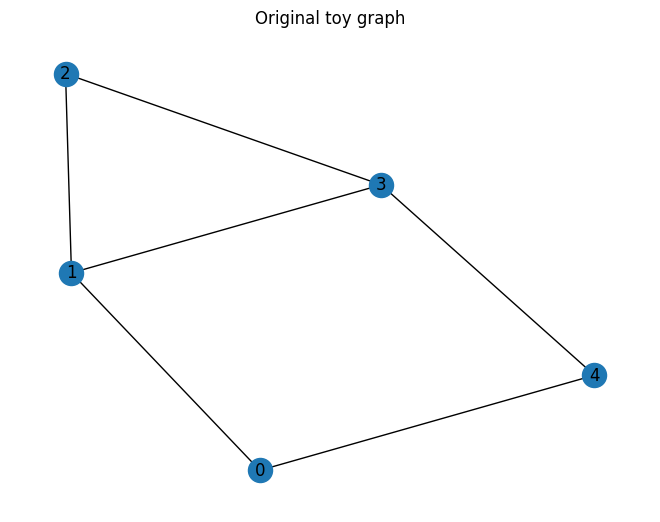

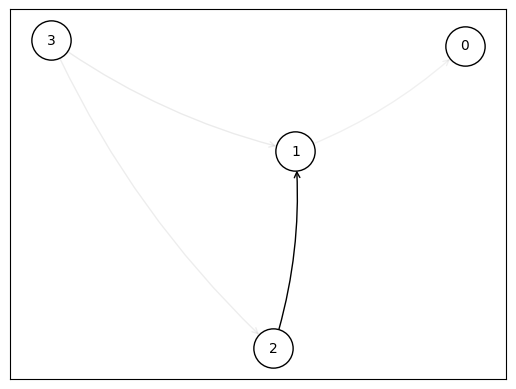

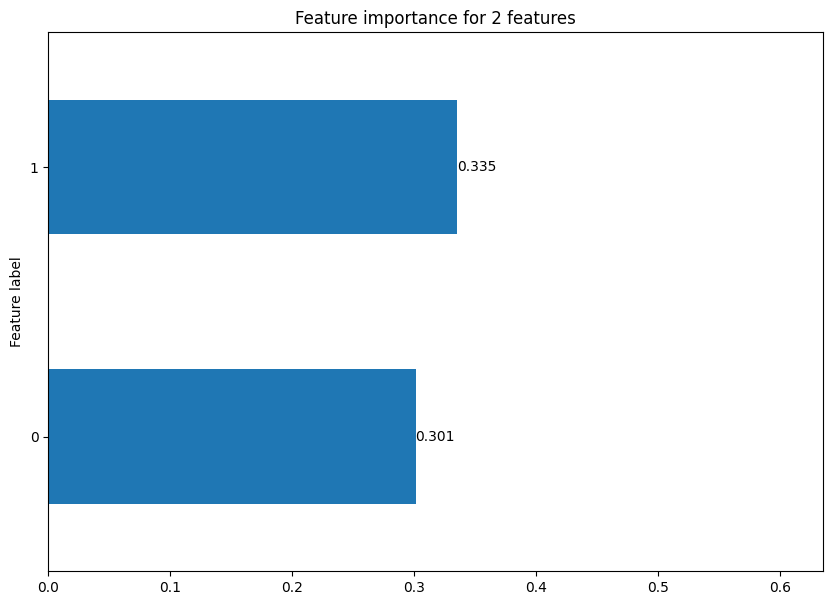

In [238]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. Create a Small Synthetic Graph
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 1],
    [1, 2, 3, 4, 0, 3]
], dtype=torch.long)

# 5 nodes, 2 features per node
x = torch.tensor([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0],
    [1, 0]
], dtype=torch.float)

# Labels for node classification
y = torch.tensor([0, 1, 0, 1, 0], dtype=torch.long)

# Create the data object
data = Data(x=x, edge_index=edge_index, y=y)

G = nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from(list(map(lambda x: (x[0].item(),x[1].item()),edge_index.T)))
nx.draw(G,with_labels=True)
plt.title("Original toy graph")
plt.show()
# 2. Define a Simple GNN Model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(2, 4)
        self.conv2 = GCNConv(4, 2)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()

# 3. Train the GNN on the Graph
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x,data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

# 4. Initialize GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
fig = plt.figure()
explanation = explainer(data.x, data.edge_index)
explanation.visualize_graph()
explanation.visualize_feature_importance()



## Using GNNExplainer for interpreting models in real-world

This code is designed to explain the decision-making process of a GVN on the **Twitch social network dataset** using the **GNNExplainer**. 

The Twitch dataset provides insights into streamers, their streaming behaviors, and whether they use explicit language during streams. This data is structured as a graph, where each **node** represents a streamer, and the **edges** indicate friendships or connections between streamers on the platform. The node features are based on the games played and liked, location and streaming habits of streamers. The features are embeddings, which cannot be interpreted directly.
<center><img src="images/twitch.png" width=600></center>
<center><small>Image from https://www.youtube.com/watch?v=aFnlmzFh4iQ </small></center>

An example of node classification task on the graph is determining whether a streamer uses explicit language. This is a binary classification problem, where each streamer is labeled as either using explicit language or not. The GNNExplainer can be used to identify which nodes contributed to predicting that a streamer uses explicit language based on their friendships.

We can use the GCN model to classify nodes into different categories. Once the model is trained (or in this case, assumed to be pre-trained), we use **GNNExplainer** to analyze the model's prediction for a specific node. The explainer tries to identify which edges (friendships) in the graph were most influential in the model's decision.

To do this, the code generates a subgraph consisting of all nodes and edges within a 3-hop radius of the target node. It uses this subgraph to visualize the relationships and highlight the most important edges. The importance of these edges is determined by the **GNNExplainer**, which assigns an importance score (or mask) to each edge, showing how much that edge contributed to the final prediction.

In the final visualization, the graph is displayed with different colors to show:
- The target node (node with index 0) for which we want to interpret the decision (in red circle).
- The overall graph structure (in green).
- The subgraph (local neighborhood) around the target node (in blue).
- The key edges identified by GNNExplainer as crucial for the node's prediction (in red).

This approach allows us to interpret and understand how the model uses graph structure to make predictions, providing insights into the decision-making process of the GCN model.

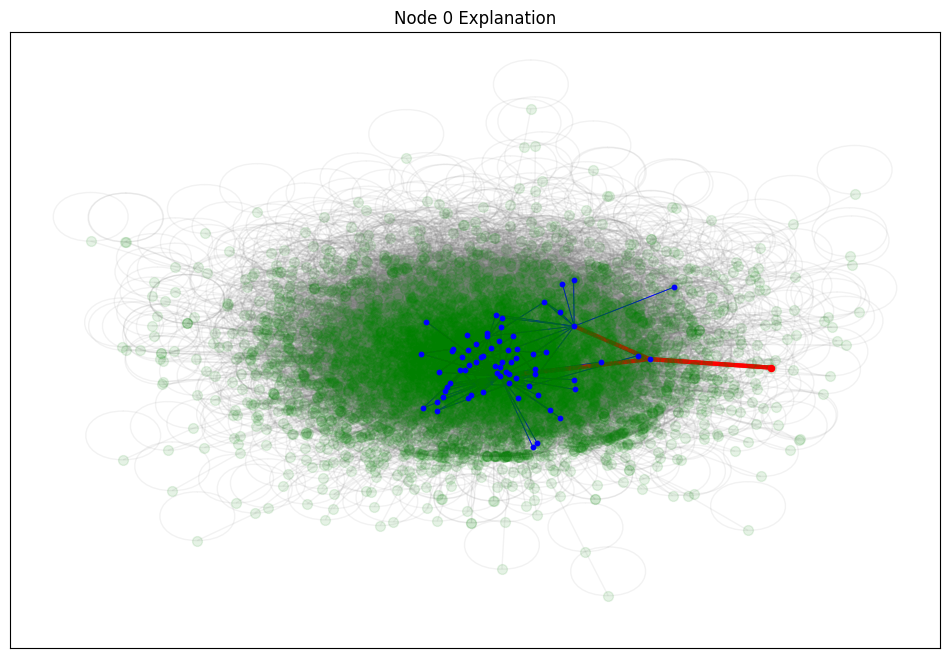

In [223]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import GNNExplainer
from torch_geometric.nn import GCN
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.datasets import Twitch

# 1. Load the dataset
dataset = Twitch('.', name="EN")
data = dataset[0]

# 2. Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(data.num_node_features, hidden_channels=64, num_layers=2,
            out_channels=dataset.num_classes).to(device)
model.eval()

# 3. Initialize GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# 4. Choose a node to explain
node_idx = 0  # Index of the node to explain
target = data.y[node_idx]

# 5. Explain the node
explaination = explainer(x=data.x, edge_index=data.edge_index, index = node_idx)

node_feat_mask, edge_mask = explaination.node_mask, explaination.edge_mask
# 6. Get the 3-hop subgraph around the node
subset, _, _, hard_edge_mask = k_hop_subgraph(node_idx, num_hops=3, edge_index=data.edge_index)

# 7. Convert the edge mask to numpy for visualization
edge_mask_np = edge_mask.cpu().numpy()
hard_edge_mask_np = hard_edge_mask.cpu().numpy()

# 8. Create NetworkX graph for visualization
G = nx.Graph()
G.add_edges_from(data.edge_index.t().cpu().numpy())
pos = nx.spring_layout(G) # Layout for visualization

plt.figure(figsize=(12, 8))

# Draw all edges
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='grey')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50, alpha=0.1, node_color='green')

nx.draw_networkx_nodes(G, pos, nodelist=subset.tolist(), node_size=10, node_color='blue')
nx.draw_networkx_nodes(G, pos, nodelist=[node_idx], node_size=20, node_color='red')
# Draw edges in the subgraph
nx.draw_networkx_edges(G, pos, edgelist=data.edge_index[:, hard_edge_mask].t().cpu().numpy().tolist(), edge_color='blue', width=0.5)

# Draw edges highlighted by GNNExplainer
highlighted_edges = data.edge_index[:, edge_mask_np > 0].t().cpu().numpy()  # Adjust threshold as needed
nx.draw_networkx_edges(G, pos, edgelist=highlighted_edges.tolist(), edge_color='red', width=3,alpha=1)


plt.title(f'Node {node_idx} Explanation')
plt.show()


The explanation also highlights which features had the greatest influence on the decision. While the embeddings for these features lack direct interpretability, if the features were not embedded, we could, for example, identify which specific games contributed to the prediction.

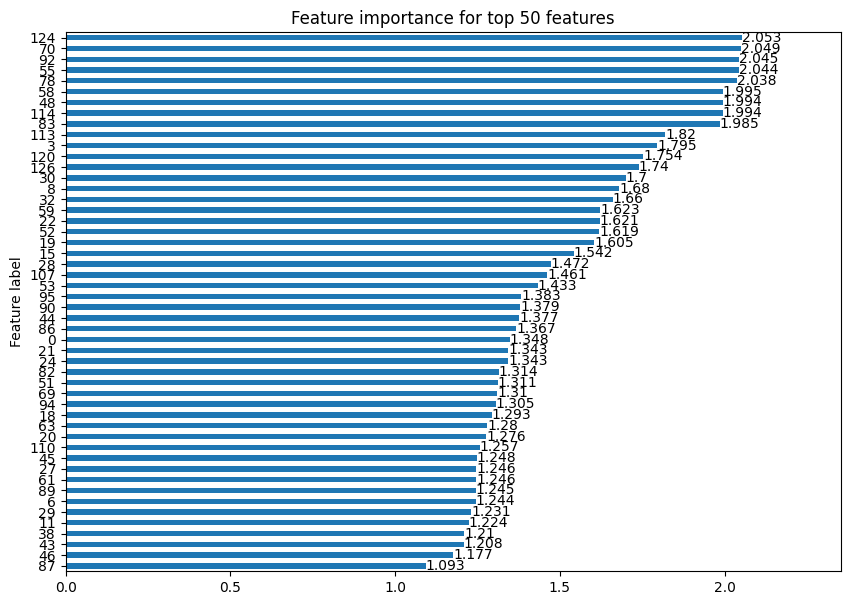

In [233]:
explaination.visualize_feature_importance(top_k=50)